# Programming Assignment 1

In this assignment, you will implement linear regression and gradient descent and visualize the results. We prompt you with questions throughout the assignment, **but you need not answer the conceptual questions in this notebook.** We hope that they will inspire you to think more deeply about the strengths and weaknesses of these algorithms.

**Assignment submission:** This assignment is to be uploaded as both a .ipynb file and a converted .pdf file **via Gradescope**. For help converting the notebook to a .pdf file, see [this document](https://bit.ly/cos324-colab-pdf). You can submit as often as you need, but only the last submission is graded, and submissions made after the deadline may incur a late penalty depending on your remaining free late hours.

## Assignment Instructions

**Programming assignments will be written in Python.** For more help with using Python, please refer to the pre-work resources in our syllabus and to the notebook from Precept 1.

* **We strongly suggest that you use Google Colab, which has many libraries pre-installed for you. *We will only be supporting Google Colab in office hours*.** We will not be able to help you with issues/instructions regarding local Python environments.
* The instructions for the assignments will provide some guidance on finding useful functions for completing the assignment, but **it will be up to you to search for the exact documentation for specific functions**. Learning to search for helpful information is an important skill for programming.
* **We expect your code to be readable and interpretable**, with meaningful variable names and comments that help us understand your code. Please refer to [PEP 8](https://www.python.org/dev/peps/pep-0008/) for guidance.
* **Consulting TAs (grad or ugrad) and other students from this course is allowed**. Please refer to our collaboration policy for guidance on what is acceptable though, as well as the caution about plagiarism and the need to cite all sources you used.
* **Consulting course staff (e.g. TAs, UCAs) and/or other students from this course is allowed.** Please refer to our collaboration policy for guidance on what is and isn't acceptable.
  * **List your collaborators for each problem in a collaboration statement in the next cell.**
  * You should also **cite all sources** you consulted per problem if they aren't a required or optional course reading. You can do this using a Python comment: `# Consulted this source: ...`.
* **You may not use unauthorized packages or libraries.** If you use code from outside sources or past/other academic work, it must be targeted toward a single and minute purpose (e.g. one or two lines of code for changing the scale of plot axes) and not make up a significant portion of your submission. If you are copying a block of code, you are likely in violation of this rule.

## Collaboration statement
List all collaborators by name, including other students and/or course staff (e.g. TAs, UCAs). If you collaborated with no one on this assignment, write the following: ``"I did not collaborate with anyone on this assignment."``

**I did not collaborate with anyone on this assignment.**


---

## I. Getting Started with Linear Regression (50 pts)

We first perform a 1-dimensional regression where we learn a linear relationship between variables X and Y. This has a simple analytic solution that you will work out by hand. Then we use the scikit-learn package to perform a n-dimensional regression.

The two regression problems use the [*diabetes* dataset](https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf) (see below). It contains real records of patients with diabetes. Do not worry as:
* These records have been completely anonymized and are 20 years old..
* Patients gave their consent

The dataset contains 442 records of diabetes patients with the following information and measurements per patient: age, sex, body mass index (BMI), average blood pressure, and six blood serum measurements. For each patient, the  *Diabetes Expression Level*  attribute contains a quantitative measure of disease progression one year later. Physicians assigned a number between 25 to 346 to each patient indicating severity of the disease (higher = more severe).

A predictor for the patient's status a year later would be very useful for designing and executing preventative care for the coming year and possibly reversing the course of the disease. An accurate predictor would probably have a strong effect on preventive behavior as well: faced with a choice between death in two years and  eating half a pound of kale every day, many patients may agree to the kale.

You are required to construct linear predictors, calculate their error on train & test data, and visualize the prediction of your predictors.

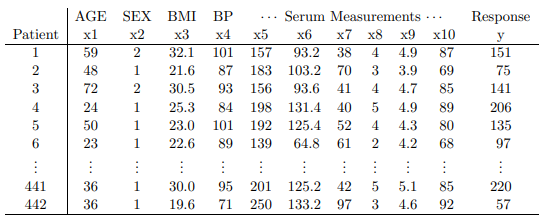

In [1]:
# Import packages
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

### A. Extract data from dataset (4 pts)

In [2]:
# Load the diabetes dataset
diabetes_dataset = datasets.load_diabetes()
diabetes_X, diabetes_y = diabetes_dataset['data'], diabetes_dataset['target'] # X (observed features) and y (diabetes expression level)
feature_names = diabetes_dataset['feature_names'] # list of observed features
print(diabetes_dataset['DESCR']) # print dataset description
print("Attributes: {}".format(feature_names))

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

When encountering a new dataset, a little *exploratory data analysis* is often useful.  A simple first step is to  see how well just **one** attribute predicts diabetes expression. Let's plot the BMI vs diabetes expression and see if it looks vaguely linear to us!

In [3]:
bmi = diabetes_X[:,2]

Text(0.5, 1.0, 'Diabetes Expression vs BMI')

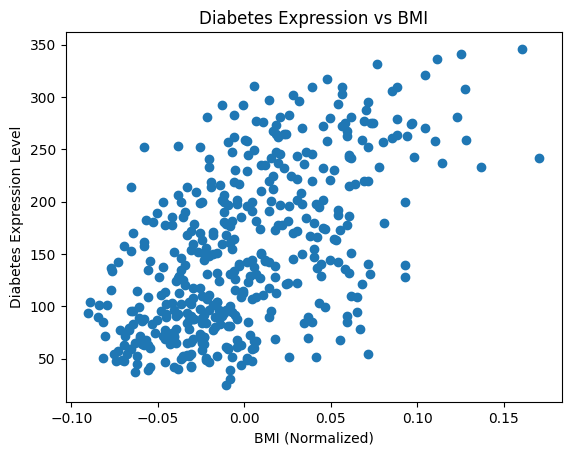

In [4]:
#TODO: extract BMI feature from diabetes_X and plot the relationship between BMI and diabetes expression level (diabetes_y)
plt.scatter(bmi, diabetes_y) # modify this line
plt.xlabel('BMI (Normalized)')
plt.ylabel('Diabetes Expression Level')
plt.title('Diabetes Expression vs BMI')

Looks pretty good -- we see some correlation. How about age?

Text(0.5, 1.0, 'Diabetes Expression vs Age')

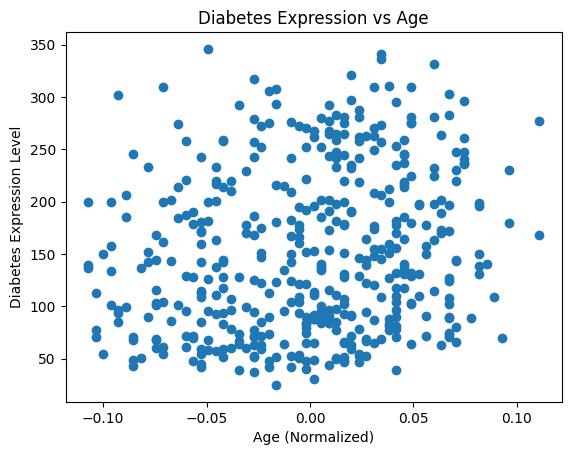

In [5]:
#TODO: extract age feature from diabetes_X and plot the relationship between BMI and diabetes expression level (diabetes_y)
age = diabetes_X[:,0]
plt.scatter(age, diabetes_y) # modify this line
plt.xlabel('Age (Normalized)')
plt.ylabel('Diabetes Expression Level')
plt.title('Diabetes Expression vs Age')

Hmm, surprisingly, age isn't very correlated. Seems like diabetes hits people of all ages. This visual check whether attribute & target have a coarse linear relationship is very useful first step for researchers building regression models, and trying to identify relevant variables. Let us proceed with BMI as our sole attribute for now.

As responsible machine learning practioner we would like to prevent overfitting. We will only fit the model using half of our data and holding out the other half for final testing of the model. (Aside: In lecture, we mentioned reserving a fifth of the dataset, which would also be fine in this setting.)

In [68]:
# Use BMI index as the sole attribute
X = diabetes_X[:,2] # TODO: Extract BMI feature from diabetes_X

# Use a half of the dataset for test
test_size = X.shape[0] // 2

# Split the data into train & test
x_train = X[:-test_size]
x_test = X[-test_size:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-test_size]
y_test = diabetes_y[-test_size:]

### B. Find a line $\hat{y} = ax + b$ by minimizing $\sum_i (\hat{y}_i - y_i)^2$ (16 pts)

Below when we say "find" we mean that you should use calculus to find the expression, and then write simple code to evaluate it on the dataset (one line of code each is enough for $a$ and $b$). In this simple setting, there's no need to use gradient descent.

1. Find $b$ such that train loss $\sum_i (a x_i + b - y_i)^2$ is minimized w.r.t $b$. (4 pts). **HINT: The data ($x_i$) is normalized. You can assume training input ($x_i$) has mean 0, and therefore $\sum_i x_i = 0$**
2. Using the value of $b$ from 1, find $a$ such that train loss $\sum_i (a x_i + b - y_i)^2$ is minimized w.r.t $a$. (4 pts)
3. Calculate the average prediction error (MSE) $\frac1m \sum_{i=1}^m (a x_i + b - y_i)^2$ on train and test data. (4 pts)
4. Print the optimal values of $a$, $b$. Print the train MSE, and test MSE. Round to four decimal places. (4 pts)

The mean squared error is a common measurement of error! Food for thought: Why do we square the error? No need to write your answer in the notebook!

In [70]:
b = np.mean(y_train)
a = (np.sum(x_train * y_train) / np.sum(x_train**2))
mse_train = np.mean(((a * x_train + b) - y_train)**2)
mse_test = np.mean(((a * x_test + b) - y_test)**2)

print(f"optimal value of a: {a: .4f}")
print(f"optimal value of b: {b: .4f}")
print(f"train MSE: {mse_train: .4f}")
print(f"test MSE: {mse_test: .4f}")

optimal value of a:  758.9344
optimal value of b:  148.1041
train MSE:  3968.5737
test MSE:  4009.0225


Now that we have fit a model and computed its error, it is our job to communicate our work effectively to people who may not know how linear regression works.  Visualizing the data and your model is often a crucial step for debugging and evaluating how well your algorithm works.

### C. Plot the results (10 pts)
1. Plot a **scatter plot showing $\hat{y}$ vs $y$** taking $y$ along the x-axis and $\hat{y}$ along the y-axis for the training set (in blue color) and for the testing set (in red) (5 pts).
2. Plot the **line** $\hat{y} = y$ in black in the same graph. This line indicates where all the points would fall if your predictor was exactly correct, so it provides a good visual reference (5 pts).

**HINT: To draw on the same graph, do not call `plt.figure()` twice**

You can find a quick start guide for Matplotlib [here](https://matplotlib.org/stable/tutorials/introductory/quick_start.html) and comprehensive documentation [here](https://matplotlib.org/stable/api/index.html).

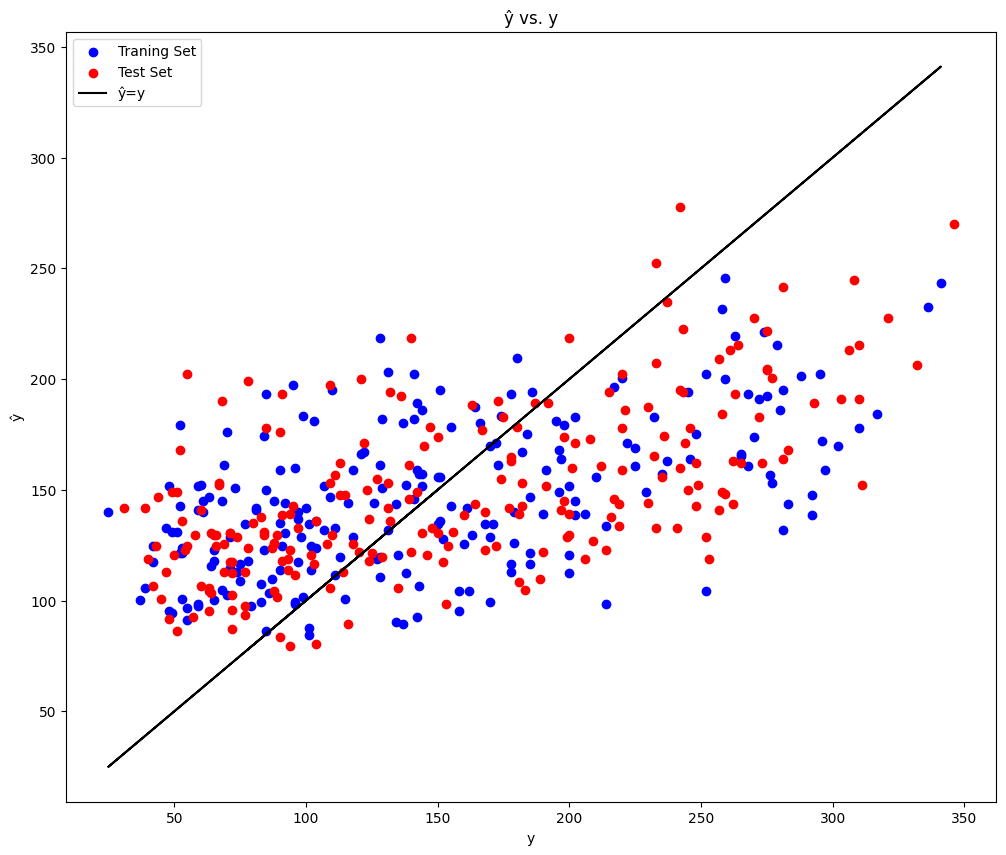

In [71]:
# part 1
y_hat_train = a * x_train + b
y_hat_test = a * x_test + b

plt.figure(figsize=(12, 10))
plt.scatter(y_train, y_hat_train, color='b',label='Traning Set')
plt.scatter(y_test, y_hat_test, color='r',label='Test Set')

# part 2
plt.plot(y_train, y_train, color='black', label='ŷ=y')


plt.xlabel('y')
plt.ylabel('ŷ')
plt.title('ŷ vs. y')
plt.legend()


plt.show()

Now that we have a sense for how good of a predictor BMI is for diabetes expression, we can try to use all of the features available to us to build a better model and see how much better  we do at prediction using all features.

To keep things simple in this assignment, you will use scikit's off-the-shelf solution. (In  next assignment you will implement gradient descent yourself.)

### D. Run regression on all dimensions of the data (20 pts)
Instead of looking at just one feature from the input, use all 10 of them:

1. Use the [LinearRegression object from scikit.linear_model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to fit the data. (5 pts)
2. Train the model on *all* features from diabetes_X. Use half of the dataset for training and half for testing. (5 pts)
3. Calculate the MSE of the fit on the train and test data. Print the results. (5 pts)
4. Create the same plot as you did above. (5 pts)

MSE on the training data: 2863.241713866172
MSE on the testing data: 2944.323820349317


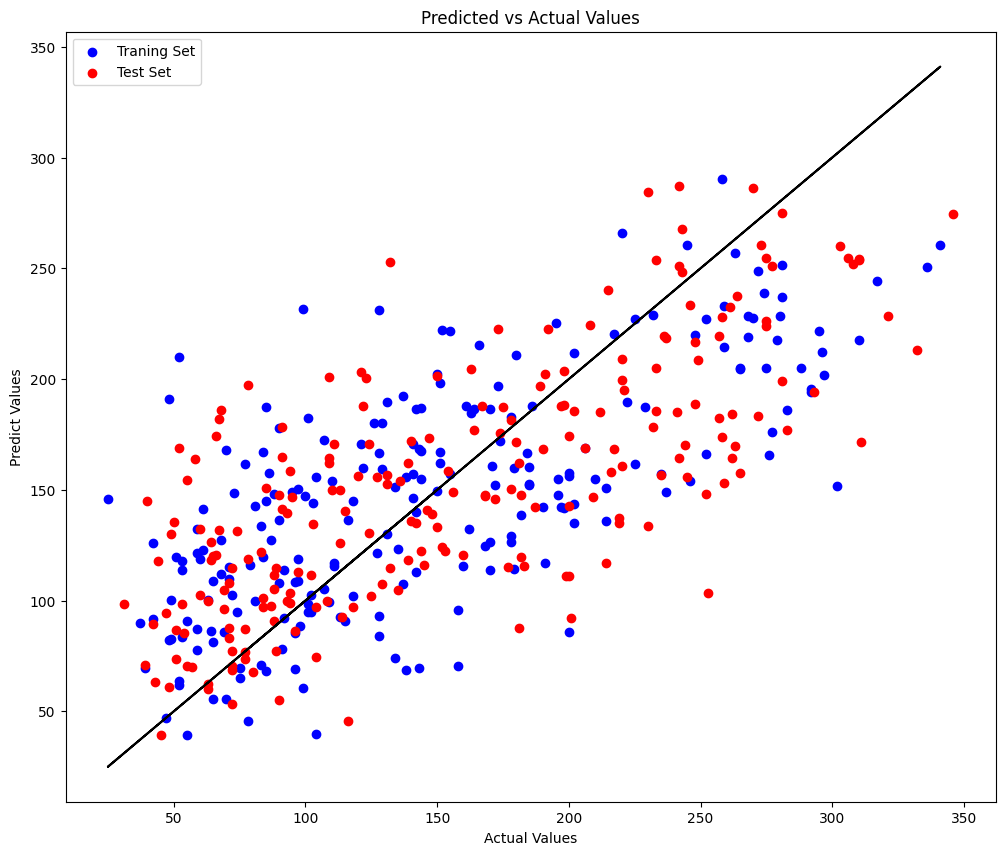

In [74]:
index = len(diabetes_X) // 2 # half way index

X_train = diabetes_X[:index]
y_train = diabetes_y[:index]
X_test = diabetes_X[index:]
y_test = diabetes_y[index:]

lr = linear_model.LinearRegression() # Linear Regression model
lr.fit(X_train, y_train)

pred_y_train = lr.predict(X_train) # predictions on training set
pred_y_test = lr.predict(X_test) # predictions on test set

mse_train = mean_squared_error(y_train, pred_y_train)
mse_test = mean_squared_error(y_test, pred_y_test)

print(f"MSE on the training data: {mse_train}")
print(f"MSE on the testing data: {mse_test}")

plt.figure(figsize=(12,10))
plt.scatter(y_train, pred_y_train, color='b',label='Traning Set')
plt.scatter(y_test, pred_y_test, color='r',label='Test Set')
plt.plot(y_train, y_train, color='black')

plt.xlabel('Actual Values')
plt.ylabel('Predict Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()

## II. Logistic Regression and Regularization (15 pts)

Next, we are going to verify the effect of L2 regularization on a simple example with logistic regresssion.

Here, we use the UCI ML Breast Cancer Wisconsin (Diagnostic) dataset, where 30 measurements of each patient are used to classify whether they have breast cancer (0 for no and 1 for yes).

The following code is provided to you. This code loads the dataset, does the train-test split and preprocesses the data by scaling. You can refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) on scaling to learn more.  

In [75]:
# importing required libraries
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [76]:
# Load the breast cancer dataset
X,y = load_breast_cancer(return_X_y = True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### A. Run logistic regression (5 pts)

Use the [LogisticRegression object from scikit.linear_model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to fit the data and report its test accuracy (round to 3 decimal places). (5 pts)

**DO NOT APPLY ANY REGULARIZATION.** You will have to read through the documentation to identify which parameter controls the regularization.

In [77]:
no_reg_lr = LogisticRegression(None)
no_reg_lr.fit(X_train, y_train)
y_pred = no_reg_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy {accuracy: .3f}")

Test Accuracy  0.939


### B. Adjust the regularization coefficient (10 pts)

Now, we apply **L2 regularization** with different values for the regularization coefficient. First, read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) again.

We provide different values of the hyperparameter C, which acts similarly to 1 / $\lambda$ from our lectures. So larger its value, the smaller the regularization effect.

1. Fit the model with the provided values of C. For each run, print the value of C along with the test accuracy (round to 3 decimal places) (5 pts). **NOTE: You can ignore any convergence warnings while fitting the model**

2. Plot the curve $\lambda$ (horizontal) vs. test accuracy (vertical) (5 pts). **Reminder: C $\approx$ 1 / $\mathbf{\lambda}$**

Value of C: 0.001
Test Accuracy: 0.886
Value of C: 0.01
Test Accuracy: 0.965
Value of C: 0.1
Test Accuracy: 0.982
Value of C: 1.0
Test Accuracy: 0.974
Value of C: 10.0
Test Accuracy: 0.974
Value of C: 100.0
Test Accuracy: 0.939


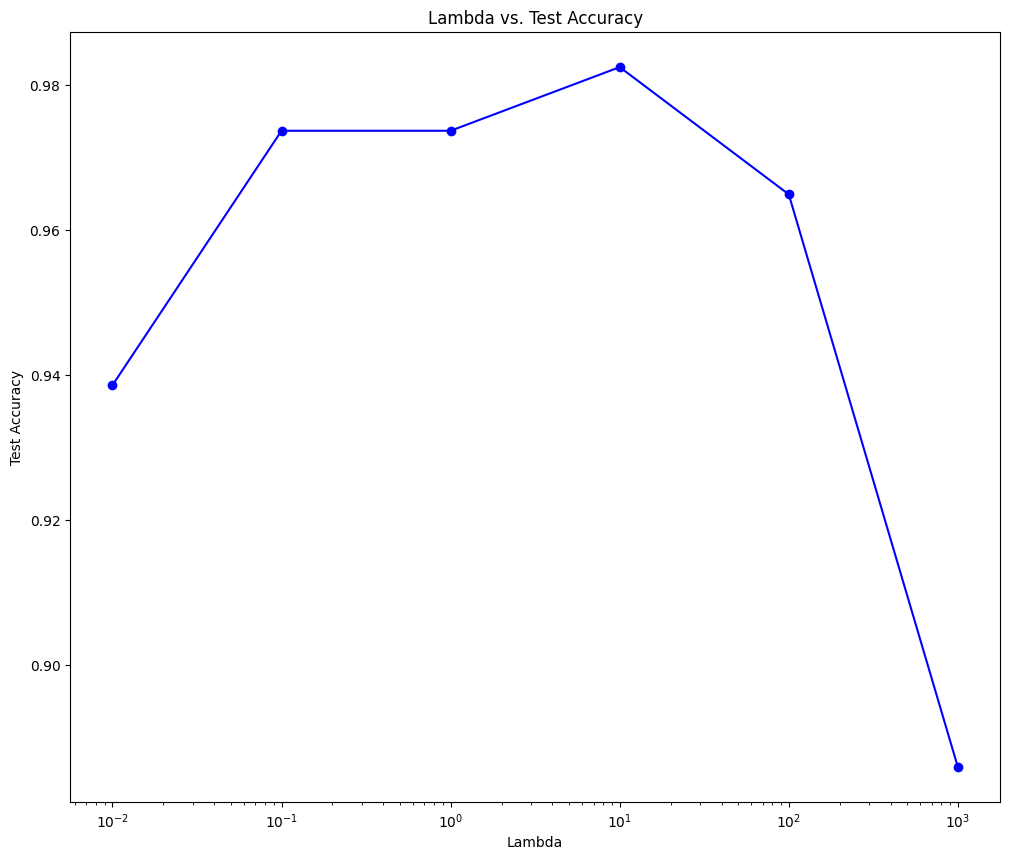

In [78]:
# Part 1
accuracy_list = []
C_list = np.array([0.001, 0.01, 0.1, 1, 10, 100])
lambda_list = 1 / C_list

for C_value in C_list:
  reg_lr = LogisticRegression(penalty='l2', C=C_value)
  reg_lr.fit(X_train, y_train)
  y_pred = reg_lr.predict(X_test)
  current_accuracy = accuracy_score(y_test, y_pred)
  accuracy_list.append(current_accuracy)

  print(f"Value of C: {C_value}")
  print(f"Test Accuracy: {current_accuracy:.3f}")

# Part 2
plt.figure(figsize=(12,10))
plt.plot(lambda_list, accuracy_list, 'bo-')
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.title('Lambda vs. Test Accuracy')
plt.xscale('log')
plt.show()

Does this align with your answer to Q5b on HW1?

Yes. In Q5b, I predicted that the mean of squared residuals will typically decrease but increase later on as lambda approaches infinity.

## III. Gradient Descent (35 pts)

Next, we are going to use gradient descent on a function of two variables, and visualize it. Make sure you read all the code we provide and understand it.

In order to run machine learning algorithms efficiently we will be using the numpy library which you have learned about. We are first going to slightly re-define the funky function of PA0 (this is to allow us to drive home the important property that initialization matters).

Funkier() computes the function

$f(x, y) = e^{-(x + 2)^2 - (y - 2)^2} + 0.25 e^{-(x - 1)^2 - (y + 1)^2} - e^{-(x + 1)^2 - (y + 1)^2} - e^{-(x - 1)^2 - (y - 1)^2}$

on a grid of values $(x, y)$ where $x \in [-4, 4]$ and $y \in [-4, 4]$, where the grid points are separated by a margin of $\delta$


Funkier_z(x, y) computes the same function only for the provided value $(x, y)$

In [79]:
import numpy as np

# X and Y can be arrays or single values...numpy will handle it!
def funkier_z(X, Y):
    Z1 = np.exp(-(X + 2)**2 - (Y - 2)**2)
    Z2 = np.exp(-(X - 1)**2 - (Y + 1)**2)
    Z3 = np.exp(-(X + 1)**2 - (Y + 1)**2)
    Z4 = np.exp(-(X - 1)**2 - (Y - 1)**2)
    Z = Z1 + 0.25 * Z2 - Z3 - Z4
    return Z

def funkier(delta=0.01):
    delta = 0.01
    x = np.arange(-4, 4, delta)
    y = np.arange(-4, 4, delta)
    X, Y = np.meshgrid(x, y)
    return X, Y, funkier_z(X, Y)



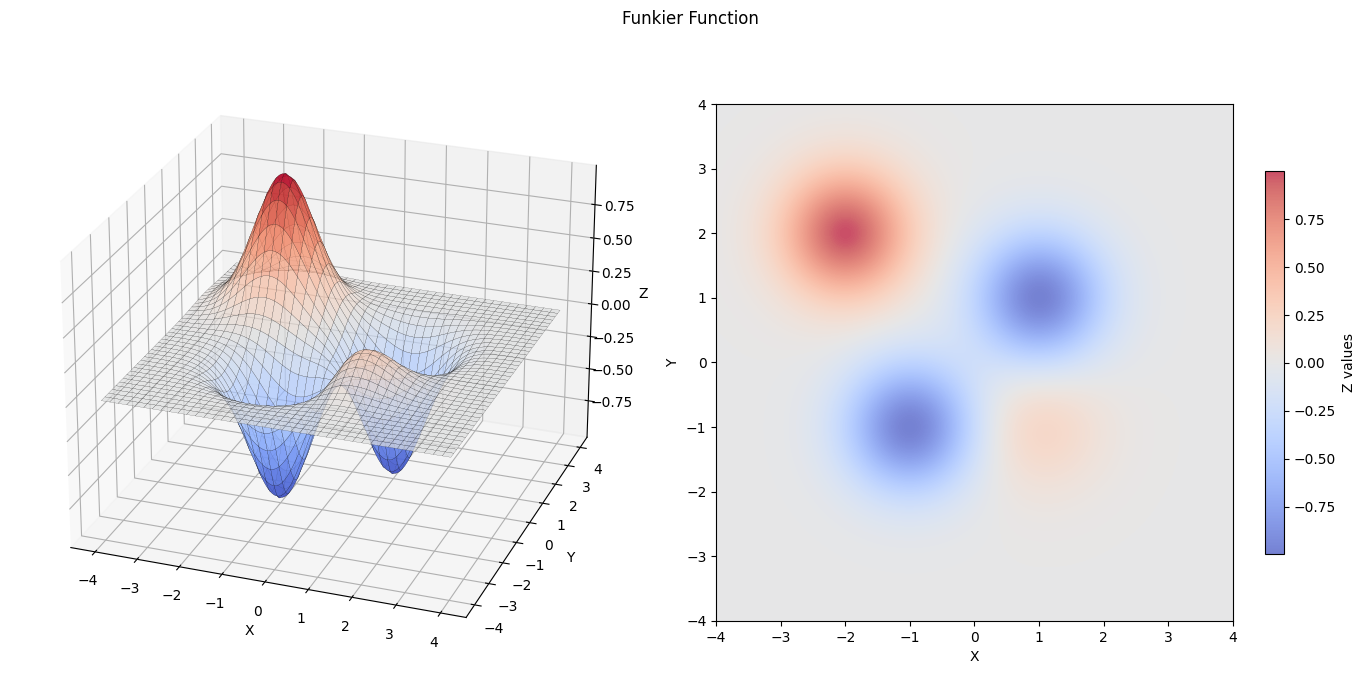

In [80]:
X, Y, Z = funkier()

# Setting the figure size and 3D projection
fig = plt.figure(figsize=(14,7))
fig.suptitle("Funkier Function")

ax_3d = fig.add_subplot(1,2,1,projection='3d')
ax_3d.set_xlabel('X')
ax_3d.set_ylabel('Y')
ax_3d.set_zlabel('Z')
p = ax_3d.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.7, rstride=20, cstride=20, linewidth=0.1, edgecolors='k')
ax_3d.view_init(elev=25, azim=-70)

# 2D plot
ax_2d = fig.add_subplot(1,2,2)
ax_2d.set_xlabel('X')
ax_2d.set_ylabel('Y')
# ax_2d.contourf(X, Y, Z, cmap=cm.coolwarm, alpha=0.7)
p = ax_2d.imshow(Z, extent=[-4, 4, -4, 4], origin='lower', cmap=cm.coolwarm, alpha=0.7)
fig.colorbar(p, ax=ax_2d, shrink=0.6, label='Z values')
plt.tight_layout()
plt.show()

This function has two local maximum and two local minima, so it's a great place for us to practice gradient descent! If we initialize gradient descent around the tallest red peak, how do you expect the trajectory to go? Keep this question in mind as you go proceed with the exercise.

### A. Implement the gradient function (10 pts)

First,  you have to implement the gradient function. For a particular $x$ and $y$, how can you compute $\frac{\partial \text{funkier}}{\partial x}$ and $\frac{\partial \text{funkier}}{\partial y}$? And so how can we write $\nabla\text{funkier}$? `funkier_grad` should return the gradient in tuple form (i.e., should return 2 values).

In [81]:
def funkier_grad(x,y):
    Z1 = np.exp(-(x + 2)**2 - (y - 2)**2)
    Z2 = np.exp(-(x - 1)**2 - (y + 1)**2)
    Z3 = np.exp(-(x + 1)**2 - (y + 1)**2)
    Z4 = np.exp(-(x - 1)**2 - (y - 1)**2)

    x_grad = (-2 * (x + 2) * Z1) + (-0.5 * (x - 1) * Z2) + (2 * (x + 1) * Z3) + (2 * (x - 1) * Z4)
    y_grad = (-2 * (y - 2) * Z1) + (-0.5 * (y + 1) * Z2) + (2 * (y + 1) * Z3) + (2 * (y - 1) * Z4)

    return x_grad, y_grad

### B. Implement Gradient Descent (15 pts)

We next implement gradient descent in order to find the minmum of **funkier**. We wrote most of the code for you.

1. Study the entire function and add an appropriate comment at the designated places. (10 pts)

2. Call `funkier_grad()` and implement the gradient step. (5 pts)


In [82]:
def funkier_minimize(x0, y0, eta):
    # Intializes two arrays filled with zeros of length of eta + 1
    x = np.zeros(len(eta) + 1)
    y = np.zeros(len(eta) + 1)

    # Assigns the first elements of the x and y array to the initial point
    x[0] = x0
    y[0] = y0
    print('\n Using starting point: ', x[0], y[0])
    for i in range(len(eta)):
        # Print the x, y, and z value every 20 iterations
        if i % 20 == 0:
            print('{0:2d}: x={1:6.3f} y={2:6.3f} z={3:6.3f}'.format(i, x[i], y[i], funkier_z(x[i], y[i])))

        xgrad, ygrad = funkier_grad(x[i], y[i])
        x[i + 1] = x[i] - eta[i] * xgrad
        y[i + 1] = y[i] - eta[i] * ygrad

        # Check if step size in x and y direction is very minimal (less then 1e-12), print that the gradient is
        # converging
        if (abs(x[i+1] - x[i]) < 1e-12) and (abs(y[i+1] - y[i]) < 1e-12):
            print('Near convergence at ({}, {})\nGradient norm {:.4g}'.format(x[i], y[i], np.sqrt(xgrad**2 + ygrad**2)))
            return x[:i+2], y[:i+2]

        # Check if x is exceeding 100 and halt iterating to stop further divergence
        if abs(x[i+1]) > 100:
            print('Oh no, diverging?')
            return x[:i+2], y[:i+2]
    return x, y

We will now set for you the maximum number of iterations and the step size.

In [83]:
max_iter = 100
eta = 0.2 * np.ones(max_iter)

We provide a function to plot the trajectory of gradient descent. It will plot the trajectory on the 3D plot in the style we generated above.

In [84]:
def plot_GD(xs, ys, zs):

    fig = plt.figure(figsize=(14,7))
    fig.suptitle(r'Gradient Descent Trajectory ($x_0={:.2f},\ y_0={:.2f}$)'.format(xs[0], ys[0]), fontsize=16)

    ax_3d = fig.add_subplot(1,2,1,projection='3d')
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    p = ax_3d.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.5, rstride=20, cstride=20, linewidth=0.1, edgecolors='k')
    ax_3d.plot(xs, ys, zs, color='orange', markerfacecolor='black', markeredgecolor='k', marker='o', markersize=5, zorder=10, alpha=0.6)

    # mark the initialization and final points
    ax_3d.text(xs[0] + 0.15, ys[0] + 0.15, zs[0], "start (z={:.3g})".format(zs[0]), color='red', fontsize=14, zorder=20)
    ax_3d.text(xs[-1] + 0.15, ys[-1] + 0.15, zs[-1], "end (z={:.3g})".format(zs[-1]), color='green', fontsize=14, zorder=20)
    ax_3d.view_init(elev=25, azim=-70)

    # 2D plot
    ax_2d = fig.add_subplot(1,2,2)
    ax_2d.set_xlabel('X')
    ax_2d.set_ylabel('Y')
    p = ax_2d.imshow(Z, extent=[-4, 4, -4, 4], origin='lower', cmap=cm.coolwarm, alpha=0.7)
    ax_2d.plot(xs, ys, color='orange', markerfacecolor='black', markeredgecolor='k', marker='o', markersize=5, zorder=10, alpha=0.6)
    ax_2d.text(xs[0] + 0.1, ys[0] + 0.1, "start (z={:.3g})".format(zs[0]), color='red', fontsize=14, zorder=20)
    ax_2d.text(xs[-1] + 0.1, ys[-1] + 0.1, "end (z={:.3g})".format(zs[-1]), color='green', fontsize=14, zorder=20)

    fig.colorbar(p, ax=ax_2d, shrink=0.6, label='Z values')
    plt.tight_layout()
    plt.plot()

Finally, it is time to unleash gradient descent and look for the global minimum of **funkier**.

Note that **funkier_minimize** only gives you the $(x,y)$ trajectory. To get the corresponding $z$ values along the trajectory, you will have to call **funkier_z**, defined previously.

Here, we demonstrate another powerful feature of numpy. You can pass in single scalars to **funkier_z**, as we did in the **funkier_minimize** function, or you can pass in entire arrays. If you give the function arrays of $x$ and $y$ values, then it will compute the function for each pair of corresponding $(x,y)$ values and return an array of $z$ values.

We start with the initialization at $(-2.5, -2.5)$. If your GD implementation is correct, you should converge to somewhere close to $(-1, -1)$ and attain $z$ of around $-1$.


 Using starting point:  -2.5 -2.5
 0: x=-2.500 y=-2.500 z=-0.011
20: x=-2.289 y=-2.289 z=-0.036
40: x=-1.100 y=-1.097 z=-0.978
60: x=-1.008 y=-0.999 z=-0.996
80: x=-1.008 y=-0.999 z=-0.996
Near convergence at (-1.0081994735590065, -0.999486132407434)
Gradient norm 3.616e-12


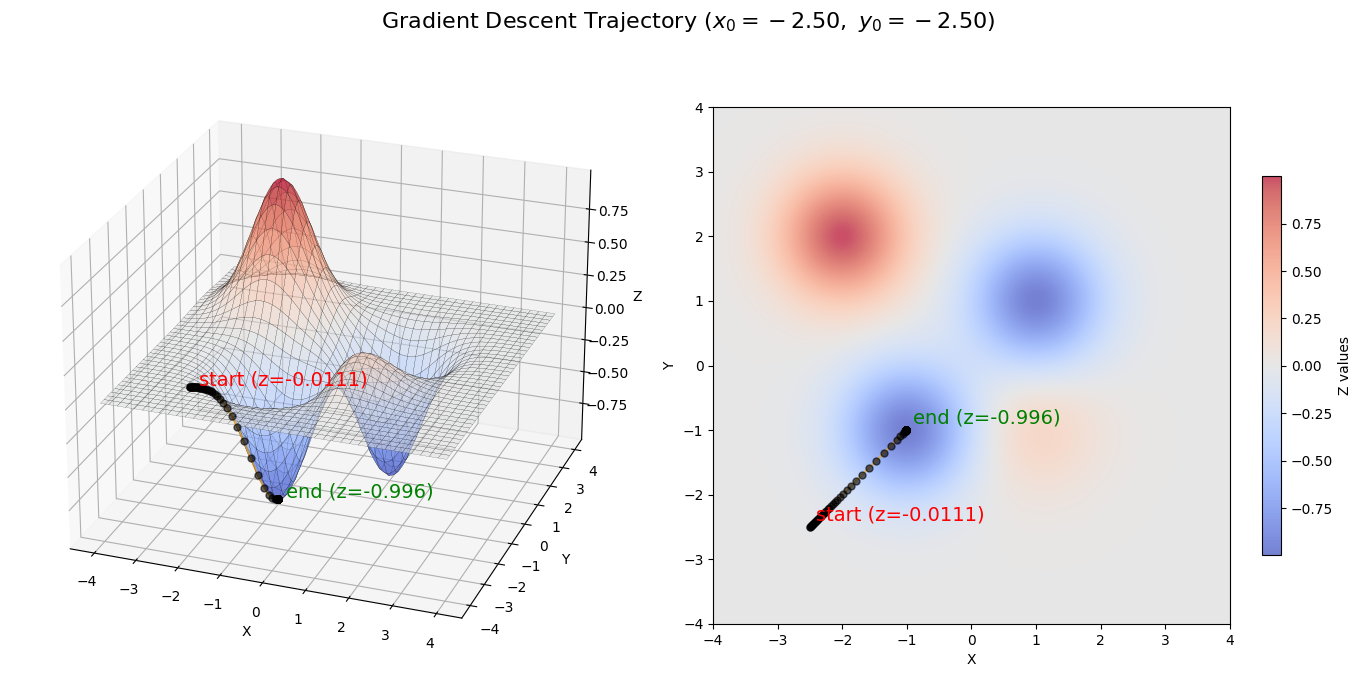

In [85]:
x_opt, y_opt = funkier_minimize(-2.5, -2.5, eta)
# the power of numpy!
z_opt = funkier_z(x_opt, y_opt)
plot_GD(x_opt, y_opt, z_opt)

### C. Running Gradient Descent (10 pts)

Now let's see how subtle difference in initialization can lead to different gradient descent trajectory. Starting from the small neighborhood of $x\in[-2.1, -1.9], y\in [1.9,2.1]$, find initializations such that GD will converge to
1. The minimum near (-1, -1) (2pts)
2. The minimum near (1, 1) (2pts)
3. Somewhere with positive z value (3pts)
4. Somewhere with negative z value but far away from the two local minima. (3pts)

Plot the trajectories starting from these initializations


**TODO: Answer here**


 Using starting point:  -2.0 1.9
 0: x=-2.000 y= 1.900 z= 0.990
20: x=-1.622 y=-0.197 z=-0.350
40: x=-1.008 y=-0.999 z=-0.996
60: x=-1.008 y=-0.999 z=-0.996
Near convergence at (-1.0081994735587732, -0.9994861324038494)
Gradient norm 3.785e-12


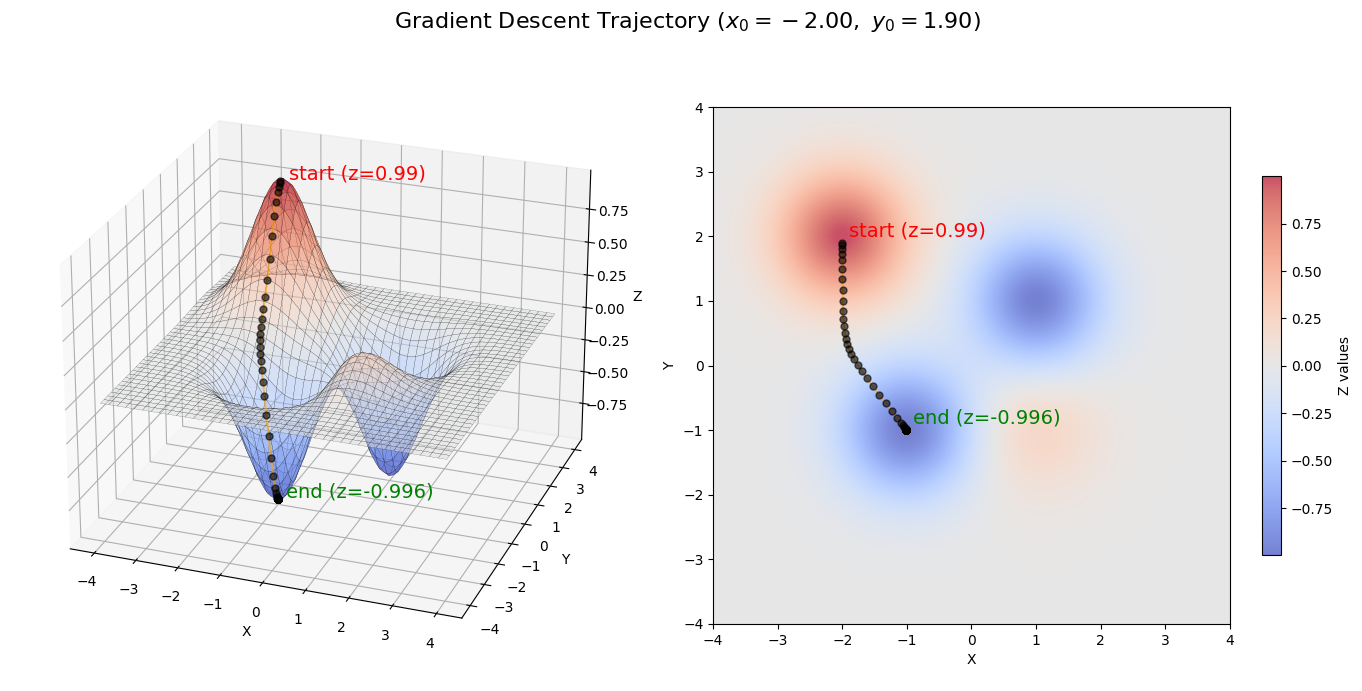

In [86]:
# C.1 minimum near (-1, -1)
x_init = -2
y_init = 1.9
x_opt, y_opt = funkier_minimize(x_init, y_init, eta)
z_opt = funkier_z(x_opt, y_opt)
plot_GD(x_opt, y_opt, z_opt)


 Using starting point:  -1.9 2.0
 0: x=-1.900 y= 2.000 z= 0.990
20: x= 0.197 y= 1.622 z=-0.350
40: x= 0.999 y= 1.008 z=-0.996
60: x= 0.999 y= 1.008 z=-0.996
Near convergence at (0.9994861324038494, 1.0081994735587732)
Gradient norm 3.785e-12


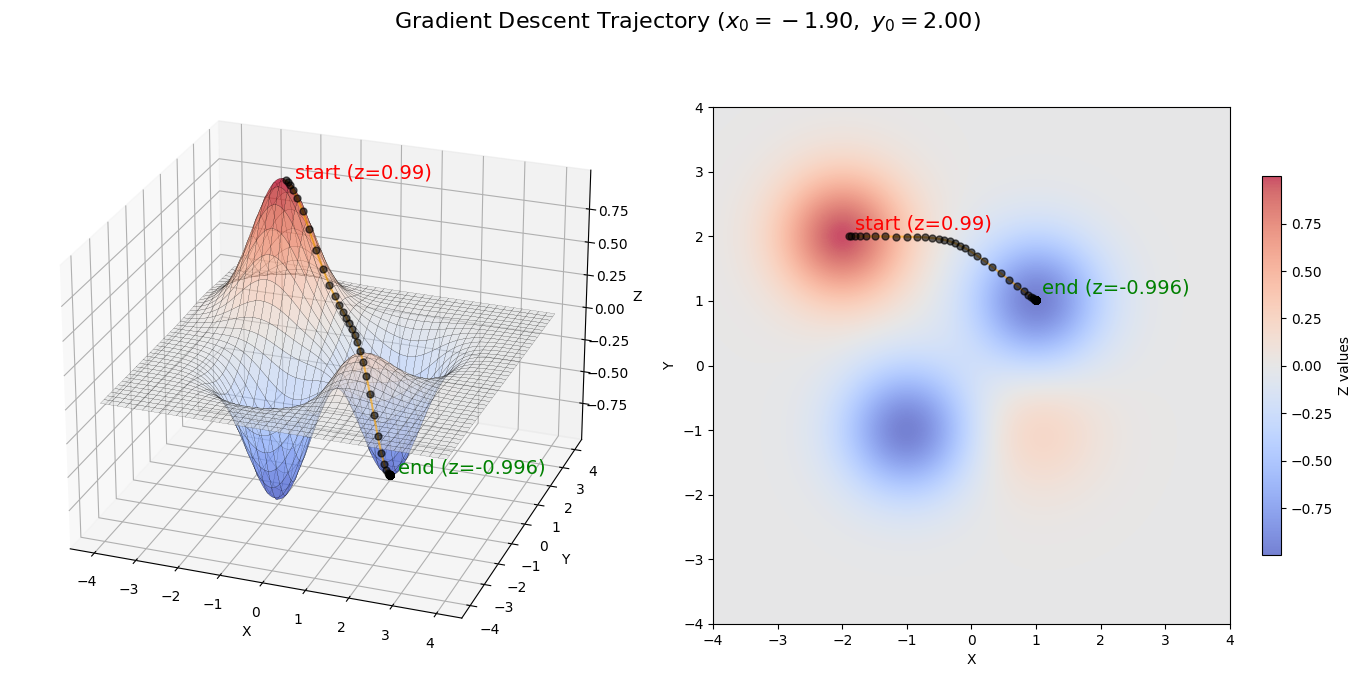

In [87]:
# C.2 minimum near (1, 1)
x_init = -1.9
y_init = 2
x_opt, y_opt = funkier_minimize(x_init, y_init, eta)
z_opt = funkier_z(x_opt, y_opt)
plot_GD(x_opt, y_opt, z_opt)


 Using starting point:  -2.1 1.9
 0: x=-2.100 y= 1.900 z= 0.980
20: x=-3.297 y= 0.689 z= 0.033
40: x=-3.499 y= 0.476 z= 0.010
60: x=-3.590 y= 0.376 z= 0.006
80: x=-3.648 y= 0.312 z= 0.004


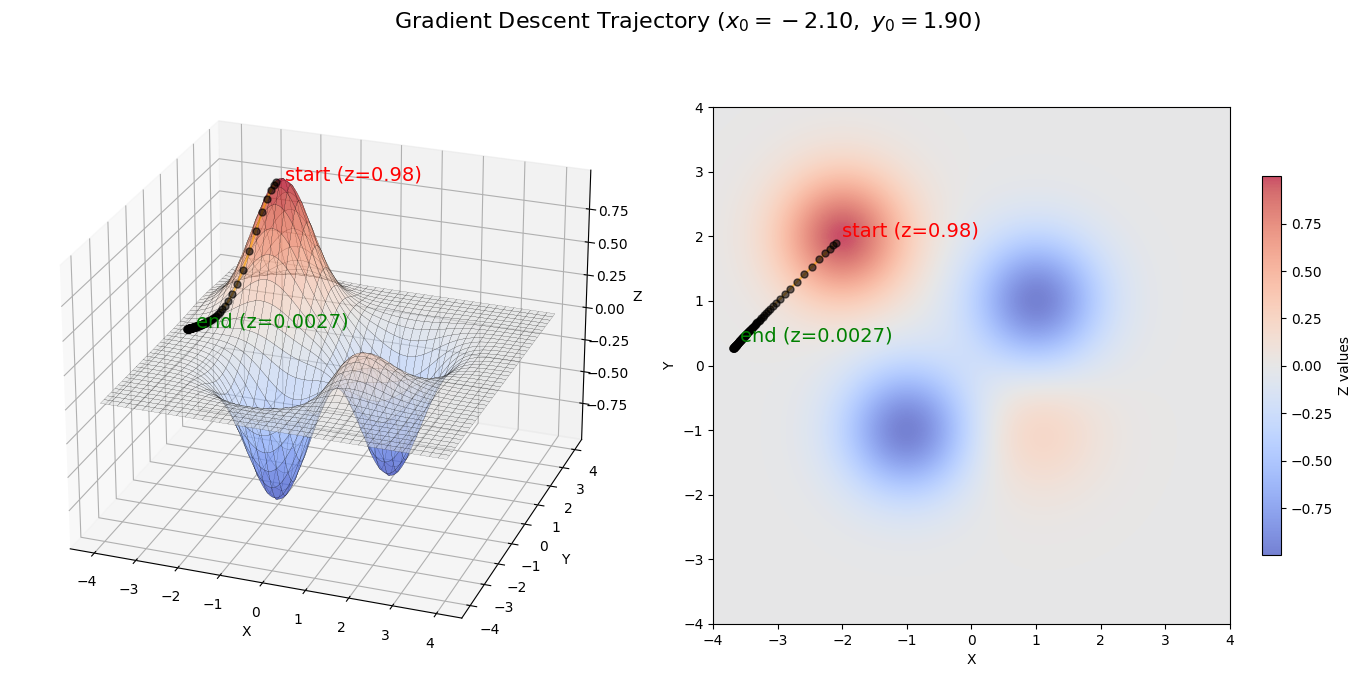

In [88]:
# C.3 GD ends with positive z
x_init = -2.1
y_init = 1.9
x_opt, y_opt = funkier_minimize(x_init, y_init, eta)
z_opt = funkier_z(x_opt, y_opt)
plot_GD(x_opt, y_opt, z_opt)


 Using starting point:  -1.9 1.9
 0: x=-1.900 y= 1.900 z= 0.980
20: x=-0.504 y= 0.504 z=-0.149
40: x=-0.120 y= 0.120 z=-0.242
60: x=-0.092 y= 0.092 z=-0.242
80: x=-0.090 y= 0.090 z=-0.242


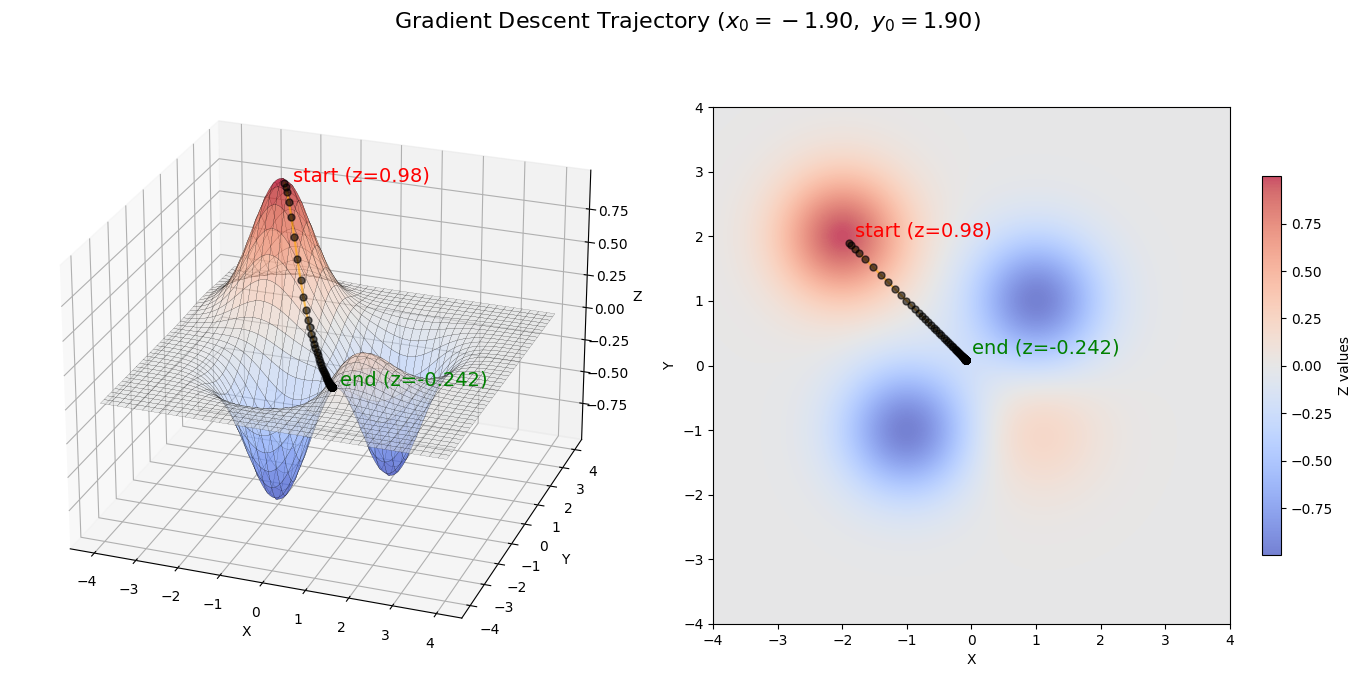

In [89]:
# C.4 GD ends with negative z, but far from minimum
x_init = -1.9
y_init = 1.9
x_opt, y_opt = funkier_minimize(x_init, y_init, eta)
z_opt = funkier_z(x_opt, y_opt)
plot_GD(x_opt, y_opt, z_opt)

# Extra credit: Optimizer visualization tool
**Max +2 points extra credit:** We expect this to take ~1 hour.

***NOTE: We will not be able to resolve queries/help with this extra credit section in office hours***. Do not attempt this until after you've completed the rest of the assignment.

In this section, you'll be using a visualization tool to explore more advanced optimizers (specifically, gradient descent with momentum and Adam) and how they compare to gradient descent.

Benefits of using advanced optimizers include:
- Faster convergence (e.g. less time needed to arrive at a minimum)
- Potential to avoid poor local minimum in non-convex losses
- Less hyperparameter tuning (e.g. finding right learning rate $\eta$).

See these resources for more on advanced optimizers:
- [Lecture 3E: Advanced optimizers (optional)](https://princeton.instructure.com/courses/11881/files/folder/lectures?preview=2412386): these optional lecture slides were modified from COS324 Spring 2023 slides (they were omitted this semester due to Labor Day affecting our lecture schedule).
- [Towards Data Science Blog](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c): this blog post was written by the author of the visualization tool (Lili Jiang) and is a nice accompaniment to the tool


**Instructions:**
Download the Gradient Descent Visualization tool ([link](https://github.com/lilipads/gradient_descent_viz/#building)). Make sure to follow the instructions for opening the tool. **For Windows** there is an error in the prebuilt app so either download the zip file from canvas ([link](https://drive.google.com/file/d/12hljMtFi-uwyQHSAhwDm-9vR61hyMrEu/view?usp=sharing)) or download the app from github and copy these files into the folder before running ([link](https://drive.google.com/file/d/1--9HWIEYTPG90vwu5xfdgceegEwQzCRC/view?usp=sharing)). **For Mac** the prebuilt app should work. If you have trouble opening it on your device, you can use Princeton Virtual Desktop ([instructions](https://princeton.service-now.com/service?id=kb_article&sys_id=KB0013394#section1)). Download the Windows .zip file in the same way and run on the virtual machine. You may get an error message about a missing file, but just hit close and the program should still run correctly.

Open the tool, choose the "Plateau" surface (first dropdown menu), and deselect Adagrad and RMSProp (leave Gradient descent, Momentum, and Adam checked).

**DO NOT CHANGE THE INITIAL POINT THROUGHOUT THIS PART. If you accidentally changed the initial point, please restart the program.**

Answer the following questions each with **1 sentence**.

## E1: Convergence speed
Keeping the default options (GD learning rate = 1e-3; momentum learning rate = 1e-3, beta = 0.8; Adam learning rate = 1e-3, Beta1 = 0.9; Beta2 = 0.999) run the visualization tool. Describe the convergence speed among the 3 methods (e.g. which converged the fastest? slowest? middle?)

Note that the "Plateau" surface has a global minimum in the center that's surrounded by a hilly ring, creating a local minimum ring outside of the hilly ring.

**Answer:** Momentum converged the fastest, followed by Adam, then Gradient Descent.

## E2: Finetuning Adam optimizer

1. Keeping the betas constant, try decreasing and increasing the learning rate for the Adam optimizer. What's the effect of increasing or decreasing the learning rate of the optimizer?  
*Note:* The learning rate of 1e-3 is $10^{-3}$ so decreasing it by a factor of 10 would make it 1e-4 (i.e. $10^{-4}$)<br><br>
**Answer:** Decreasng the learning rate slows down the Adam optimizer's convergence while increasing it sped it up but also made the Adam Optimizer rapidly go back and forth from the plateau and the global maximums.

2. Keeping the betas constant, try decreasing and increasing the learning rate and identify a **range of learning rates** for which Adam converges at the global minimum.<br><br>
**Answer:** 1e-2 to 1e-1.



## E3: Finetuning Momentum optimizer (i.e. gradient descent with momentum)

1. Keeping the learning rate constant, try setting the decay rate = 1 as well as decay rate = 0 (and values in between) for the momentum optimizer (Note: the decay rate in the visualizer is $\beta$ in the formula from the Lec3E slides). What's the effect of the decay rate (e.g. what happens when the decay rate is high, i.e. decay rate = 1; when it's low?)<br><br>
**Answer:** When the decay rate is high, the momentum optimizer rapidly oscillates through the global min and converges at a local min while when the decay rate is low the momentum optimizer slowly converges to a local min.

2. Reset decay rate = 0.8, try decreasing and increasing the learning rate and identify a learning rate for which momentum converges to the global minimum.<br><br>
**Answer:** Learning rate of 1e-2.

3. Reset decay rate = 0.8 for momentum and describe what happens when you run the visualization with lr = 1e-1 and lr = 1e-0 (you may want to set the playback speed to 0.2x). Does it converge, diverge, or oscillate?<br><br>
**Answer:** The momentum optimizer when set with a lr = 1e-1 converges to a local min after a bit of oscillation while oscillating constantly with lr = 1e-0 and no convergence.

## E4: Finetuning gradent descent optimizer

Try increasing and decreasing the learning rate for gradient descent to identify one for which gradient descent converges to the global minimum. You'll most likely struggle to identify such a learning rate.

1. Try lr = 1e-1 (set playback speed to 0.2x) and observe its behavior. Explain why it doesn't converge to the global minimum. <br><br>
**Answer:** It does not converge to a global min because it is unable to pass over the local min (does not have enough momentum to overcome a small hill).


2. Try lr = 1e-0 (set playback speed to 0.2x) and observe its behavior. Explain the behavior you observe. \

**Answer:** The GD optimizer never converges and rather changes location near the global maximums, the corners of the plateau.

## E5: Saddlepoint visualization

Change the surface to "Saddle Point" and reset Gradient Descent, Momentum, and Adam to the default values (GD: lr = 1e-3; Momentum: lr = 1e-3, decay rate = 0.8; Adam: lr = 1e-3, Beta1 = 0.9, Beta2 = 0.999).


1. Run the visualization tool for all 3 methods with the "Path" option checked and describe what you observe about each method's convergence in terms of speed of convergence and direction of path (no need to explain why for now, just what you observe). <br><br>
**Answer:** The Adam optimizer converges the fast toward the global min, the momentum optimizer converges the second fastest first outward but then toward the global min, and the Gradient Descent optimizer is the slowest but with the spam path as momentum.

2. Re-run the visualization tool several times and experiment with viewing it with each of the following options: Gradient Arrows (i.e. the gradient $\nabla L$), Momentum Arrows (i.e. the vector $\vec{\mathbf{v}}$ from course notes) , Adjusted Gradient Arrows (i.e. the vector subtracted from $\vec{\mathbf{w}}$ in each method's gradient update rule). With these visualizations and what you know about each of the 3 methods, how would you explain the behavior of each method in terms of speed of convergence and direction of path (i.e. the "why" of what you observed, **max 2 sentences**). <br><br>
**Answer:** Gradient Descent is the basic method using step size to converge slowly in the direction of the steepest descent while momentum provides faster convergence in the direction of the steepest descent by using momentum to overcome areas that would throw off gradient descent. Adam, with the fastest convergence speed seems to update learning rates based on past movement which allows it to quickly converge to the global min.